In [26]:
import geopandas as gpd # Geospatial data operations
import numpy as np # Numeric data operations
import pandas as pd # Tabular data operations
from glob import glob # Finding files
import os
import matplotlib # Plotting
import contextily as cx # Basemaps
cx.set_cache_dir("tile_cache")
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
from tqdm.auto import tqdm # Progress bars
import matplotlib.pyplot as plt
from libpysal.cg import alpha_shape_auto
tqdm.pandas()
matplotlib.rcParams['figure.figsize'] = (20, 10)
files = glob("Onehunga_POI0322/*.shp")
files

['Onehunga_POI0322/onehunga_park.shp',
 'Onehunga_POI0322/onehunga_medical_point.shp',
 'Onehunga_POI0322/onehunga_supm_conve.shp',
 'Onehunga_POI0322/onehunga_rest_cafe.shp',
 'Onehunga_POI0322/onehunga_busstop_point.shp',
 'Onehunga_POI0322/onehunga_school.shp']

In [2]:
dfs = []
for f in files:
    # Read in each shapefile
    df = gpd.read_file(f)
    # Record the category based on the filename
    df["category"] = os.path.splitext(os.path.basename(f))[0].replace("onehunga_", "")
    dfs.append(df)

# Reproject to NZGD2000 (EPSG:2193), so units are in meters, not degrees
df = pd.concat(dfs).to_crs(2193)
# Drop bad rows (no geometry)
df.dropna(subset="geometry", inplace=True)
df.reset_index(inplace=True, drop=True)
df

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,Y,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,-36.922669,174.800483,Captain Springs Reserve,ChIJ9a8JjstIDW0RHfIbxw4LzxM,POINT (1760369.380 5912192.154),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,-36.911138,174.800399,Oranga Plunket Clinic,ChIJRdAHp8ZIDW0RvEv6agNJR4E,POINT (1760386.025 5913471.627),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,-36.924106,174.789916,Rowe Reserve East,ChIJ-frCEAJJDW0RM_Urv0pjHvE,POINT (1759425.142 5912050.503),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,-36.920526,174.792803,Buch Park,ChIJhYjfdLZIDW0RdOS3nEfuzbg,POINT (1759689.719 5912442.763),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,32.0,-36.918464,174.775892,Robert Howell Teacher Of Singing Piano And Violin,ChIJ8zT2DKlIDW0RqZ5MGkB41io,POINT (1758187.572 5912699.763),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,33.0,-36.920439,174.800548,Youth Skills Nz Ltd,ChIJhxXXvM5IDW0RGPqkwj4Zc_A,POINT (1760379.860 5912439.432),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,36.0,-36.909680,174.780656,Alexander Technique Auckland - Jann McMichael,ChIJW_dPiKNIDW0RAWDnHQc12Fs,POINT (1758630.188 5913666.441),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,37.0,-36.918265,174.770806,Onehunga High School English Language School,ChIJaY-HRQJGDW0RQO2XIwz5phQ,POINT (1757734.906 5912730.267),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


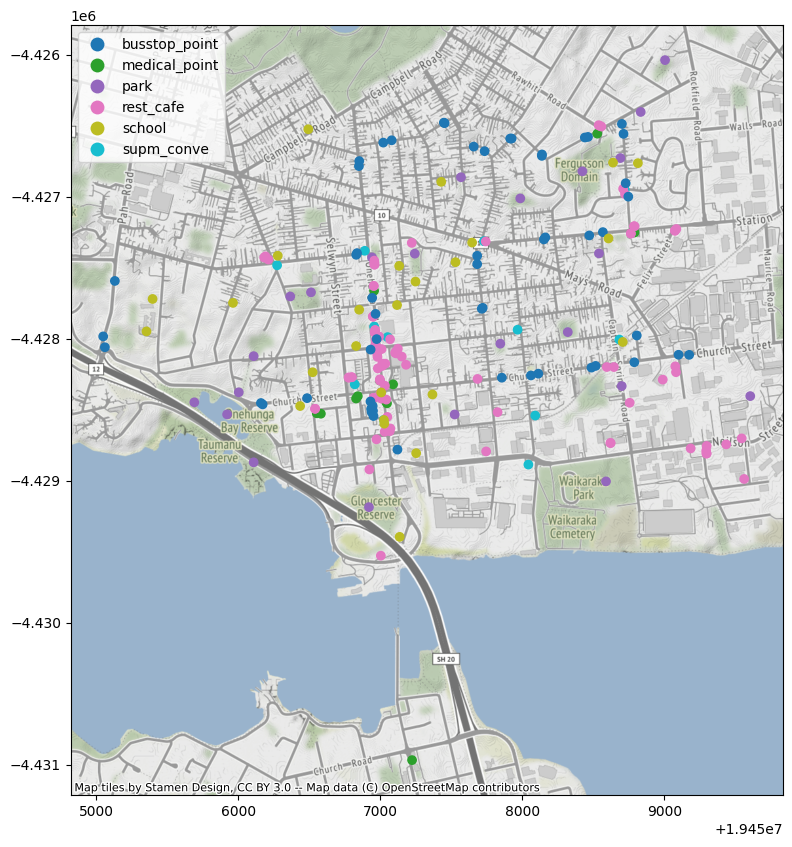

In [3]:
ax = df.to_crs(epsg=3857).plot(column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [4]:
# Distance calculation
for c in df.category.unique():
    points_in_category = df[df.category == c]
    # sindex.nearest will return the closest point within this category for each element in df.geometry
    indices, distances = points_in_category.sindex.nearest(df.geometry, return_distance=True)
    df[f"nearest_{c}"] = points_in_category.index[indices[1]]
    df[f"nearest_{c}_distance_m"] = distances
df[df.columns[df.columns.str.startswith("nearest")]]

,nearest_park,nearest_park_distance_m,nearest_medical_point,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m
0,0,0.000000,36,590.025525,44,496.858283,88,211.290628,197,360.558330,218,240.441996
1,1,0.000000,31,860.403844,41,261.268927,126,104.075998,153,151.234066,220,247.500057
2,2,0.000000,27,188.876672,48,180.339191,132,173.100288,167,137.103061,204,48.805781
3,3,0.000000,32,386.003804,44,400.332350,91,237.351935,147,336.527784,208,168.054720
4,4,0.000000,32,645.892148,46,124.991587,91,235.795972,147,190.992889,208,476.945562
...,...,...,...,...,...,...,...,...,...,...,...,...
219,8,320.710845,24,778.714386,47,326.137857,56,309.515961,182,583.467296,219,0.000000
220,1,247.500057,31,613.196811,41,23.383489,127,149.331308,198,87.040715,220,0.000000
221,5,804.469904,28,979.367432,45,752.951594,57,753.090981,179,338.401875,221,0.000000
222,15,625.817057,24,1125.738461,47,726.775427,56,670.716967,195,235.472247,222,0.000000


In [5]:
# Adapted from https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
network_type = "walk"
trip_time = 15  # in minutes
travel_speed = 4.5  # walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

In [6]:
buffer = meters_per_minute * (trip_time + 5)
buffer

1500.0

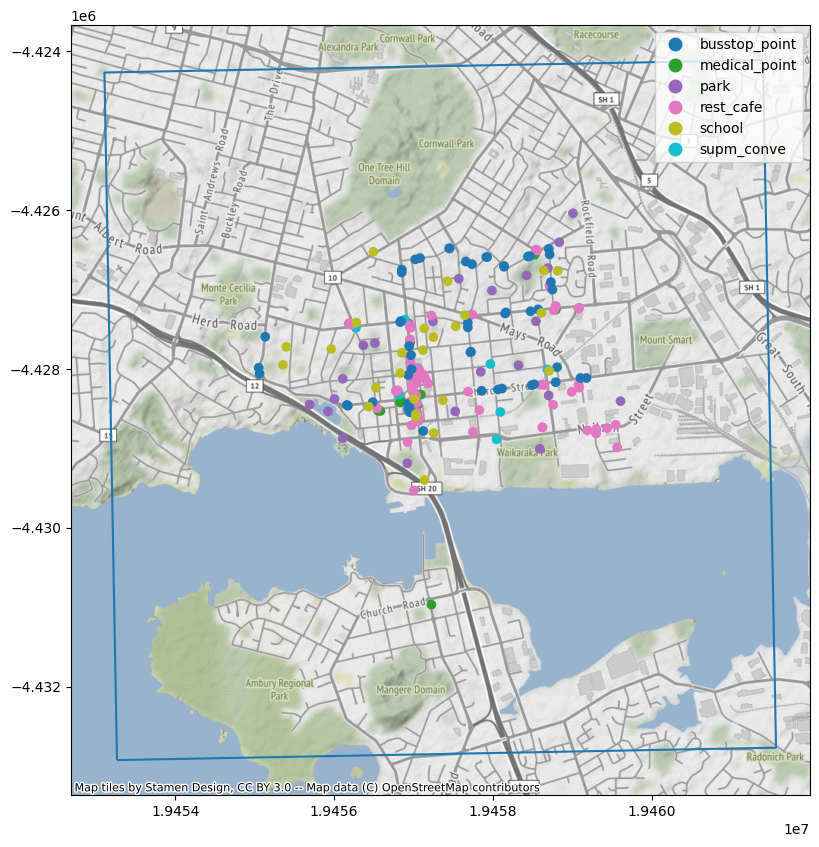

In [7]:
# Calculate Area of Interest (AOI). This is the bounds of the dataset, plus a buffer
AOI = df.dissolve().buffer(buffer).envelope
ax = AOI.to_crs(epsg=3857).boundary.plot()
df.to_crs(epsg=3857).plot(ax=ax, column='category', categorical=True, legend=True)
cx.add_basemap(ax)

In [8]:
# download the street network
G = ox.graph_from_polygon(AOI.to_crs(4326)[0], network_type=network_type)
# project the graph to 2193 CRS (units in meters)
G = ox.project_graph(G, 2193)
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [30]:
def get_isochrone_polygon(point):
    x, y = point.coords[0]
    # Get the closest node to the given point
    center_node = ox.distance.nearest_nodes(G, x, y)
    # Filter the street network to just the nodes accessible within trip_time minutes
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # Get just the x,y points from the subgraph
    node_points = np.array([[data["x"], data["y"]] for node, data in subgraph.nodes(data=True)])
    # Calculate the alpha shape
    return alpha_shape_auto(node_points)

df["isochrone_polygon"] = df.geometry.progress_apply(get_isochrone_polygon)

  0%|          | 0/224 [00:00<?, ?it/s]

In [31]:
# Take the first row as a sample, to plot isochrone results
sample = df.loc[0:0]
sample

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,Y,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE,nearest_park,nearest_park_distance_m,nearest_medical_point,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m,isochrone_polygon
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,36,590.025525,44,496.858283,88,211.290628,197,360.55833,218,240.441996,"POLYGON ((1759103.410 5912442.028, 1759205.097..."


In [32]:
# get one color for each category
colors = ox.plot.get_colors(n=len(df.category.unique()), cmap="plasma", start=0, return_hex=True)
print(colors)

['#0d0887', '#6a00a8', '#b12a90', '#e16462', '#fca636', '#f0f921']


0    496361.043181
dtype: float64


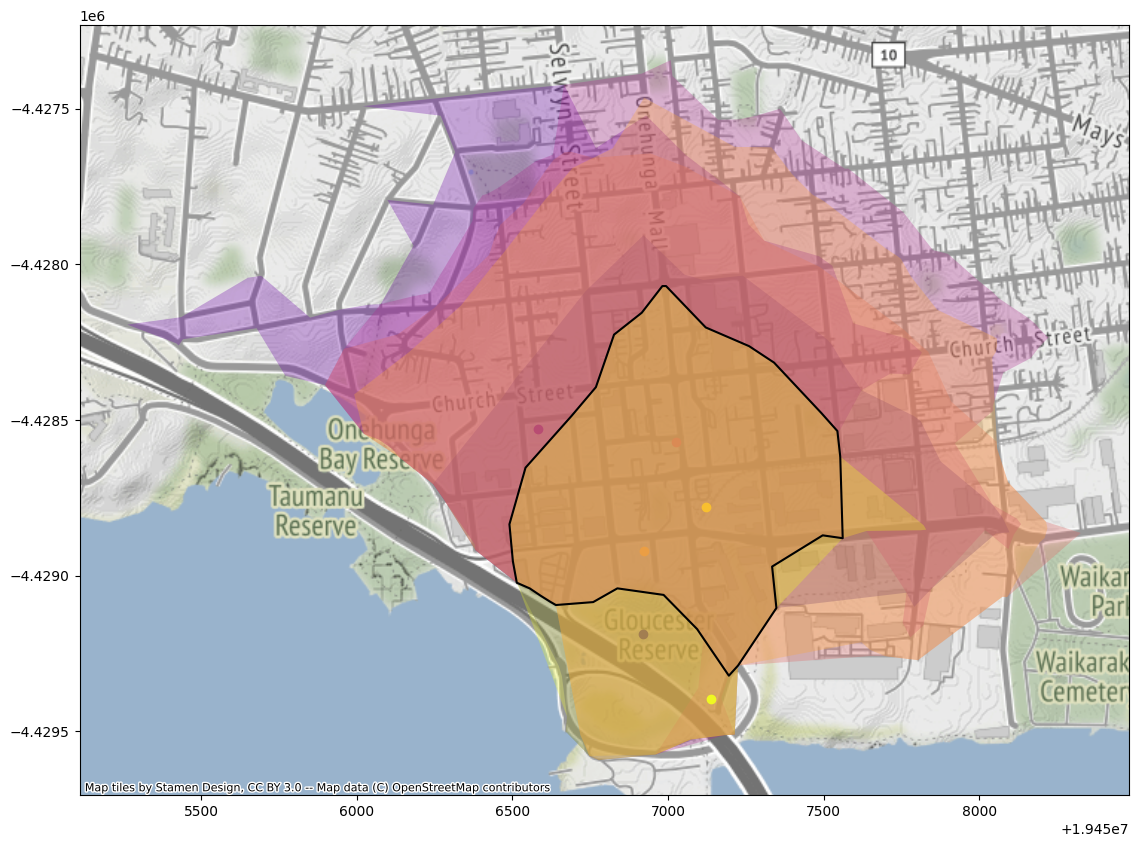

In [33]:
ax = plt.axes()
poly = sample.isochrone_polygon
for i, c in enumerate(df.category.unique()):
    color = colors[i]
    other = df.loc[sample[f"nearest_{c}"]]
    other.to_crs(epsg=3857).plot(ax=ax, color=color)
    other.isochrone_polygon.to_crs(epsg=3857).plot(ax=ax, alpha=.3, color=color)
    poly = poly.intersection(other.isochrone_polygon.iloc[0])
print(poly.area)
poly.boundary.to_crs(epsg=3857).plot(ax=ax, color="black")
cx.add_basemap(ax, zoom=15)

In [34]:
def get_isochrone_intersection(row):
    poly = row.isochrone_polygon
    for c in df.category.unique():
        other = df.loc[row[f"nearest_{c}"]]
        poly = poly.intersection(other.isochrone_polygon)
    return poly

df["isochrone_intersection"] = df.progress_apply(get_isochrone_intersection, axis=1)
df["isochrone_intersection"]

  0%|          | 0/224 [00:00<?, ?it/s]

0      POLYGON ((1759447.038 5911983.271, 1759449.471...
1      POLYGON ((1760726.182 5912360.918, 1760690.731...
2      POLYGON ((1759795.320 5913399.368, 1759780.764...
3      POLYGON ((1759308.367 5912876.236, 1759313.957...
4      POLYGON ((1759352.667 5912979.355, 1759444.918...
                             ...                        
219    POLYGON ((1758125.924 5912191.044, 1758024.481...
220    POLYGON ((1760135.332 5913143.635, 1760215.288...
221    POLYGON ((1758628.883 5912919.252, 1758540.161...
222    POLYGON ((1757745.497 5912304.898, 1757745.668...
223    POLYGON ((1760020.788 5912890.147, 1759776.150...
Name: isochrone_intersection, Length: 224, dtype: geometry

In [35]:
df["isochrone_intersection_area"] = df.isochrone_intersection.area
df

,poi_ID,Lat,Lng,name,place_id,geometry,category,Field1,_id,X,Y,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTY,STOPLAT,STOPLON,PARENTSTAT,MODE,nearest_park,nearest_park_distance_m,nearest_medical_point,nearest_medical_point_distance_m,nearest_supm_conve,nearest_supm_conve_distance_m,nearest_rest_cafe,nearest_rest_cafe_distance_m,nearest_busstop_point,nearest_busstop_point_distance_m,nearest_school,nearest_school_distance_m,isochrone_polygon,isochrone_intersection,isochrone_intersection_area
0,0.0,-36.928792,174.784494,Gloucester Park,ChIJP2senE1PDW0R9c-WycX1xlQ,POINT (1758932.401 5911539.652),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,36,590.025525,44,496.858283,88,211.290628,197,360.558330,218,240.441996,"POLYGON ((1759103.410 5912442.028, 1759205.097...","POLYGON ((1759447.038 5911983.271, 1759449.471...",4.963610e+05
1,1.0,-36.922669,174.800483,Captain Springs Reserve,ChIJ9a8JjstIDW0RHfIbxw4LzxM,POINT (1760369.380 5912192.154),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000000,31,860.403844,41,261.268927,126,104.075998,153,151.234066,220,247.500057,"POLYGON ((1760215.288 5913172.282, 1760250.129...","POLYGON ((1760726.182 5912360.918, 1760690.731...",6.412914e+05
2,3.0,-36.911138,174.800399,Oranga Plunket Clinic,ChIJRdAHp8ZIDW0RvEv6agNJR4E,POINT (1760386.025 5913471.627),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.000000,27,188.876672,48,180.339191,132,173.100288,167,137.103061,204,48.805781,"POLYGON ((1761096.102 5913464.102, 1761009.380...","POLYGON ((1759795.320 5913399.368, 1759780.764...",1.290601e+06
3,4.0,-36.924106,174.789916,Rowe Reserve East,ChIJ-frCEAJJDW0RM_Urv0pjHvE,POINT (1759425.142 5912050.503),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.000000,32,386.003804,44,400.332350,91,237.351935,147,336.527784,208,168.054720,"POLYGON ((1758462.838 5911895.125, 1758518.643...","POLYGON ((1759308.367 5912876.236, 1759313.957...",9.628418e+05
4,5.0,-36.920526,174.792803,Buch Park,ChIJhYjfdLZIDW0RdOS3nEfuzbg,POINT (1759689.719 5912442.763),park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0.000000,32,645.892148,46,124.991587,91,235.795972,147,190.992889,208,476.945562,"POLYGON ((1760185.411 5913045.911, 1760211.853...","POLYGON ((1759352.667 5912979.355, 1759444.918...",8.696736e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,32.0,-36.918464,174.775892,Robert Howell Teacher Of Singing Piano And Violin,ChIJ8zT2DKlIDW0RqZ5MGkB41io,POINT (1758187.572 5912699.763),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,320.710845,24,778.714386,47,326.137857,56,309.515961,182,583.467296,219,0.000000,"POLYGON ((1759133.539 5913045.626, 1759136.053...","POLYGON ((1758125.924 5912191.044, 1758024.481...",6.422660e+05
220,33.0,-36.920439,174.800548,Youth Skills Nz Ltd,ChIJhxXXvM5IDW0RGPqkwj4Zc_A,POINT (1760379.860 5912439.432),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,247.500057,31,613.196811,41,23.383489,127,149.331308,198,87.040715,220,0.000000,"POLYGON ((1759580.531 5912771.495, 1759563.859...","POLYGON ((1760135.332 5913143.635, 1760215.288...",7.798897e+05
221,36.0,-36.909680,174.780656,Alexander Technique Auckland - Jann McMichael,ChIJW_dPiKNIDW0RAWDnHQc12Fs,POINT (1758630.188 5913666.441),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,804.469904,28,979.367432,45,752.951594,57,753.090981,179,338.401875,221,0.000000,"POLYGON ((1758090.865 5914169.594, 1758222.275...","POLYGON ((1758628.883 5912919.252, 1758540.161...",5.677383e+05
222,37.0,-36.918265,174.770806,Onehunga High School English Language School,ChIJaY-HRQJGDW0RQO2XIwz5phQ,POINT (1757734.906 5912730.267),school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,625.817057,24,1125.738461,47,726.775427,56,670.716967,195,235.472247,222,0.000000,"POLYGON ((1758309.646 5912038.468, 1758261.853...","

In [36]:
# to_file will object to there being multiple geometry columns, so convert isochrone_polygon and isochrone_intersection to WKT
if isinstance(df.isochrone_polygon, gpd.GeoSeries):
    df.isochrone_polygon = df.isochrone_polygon.to_wkt()
    df.isochrone_intersection = df.isochrone_intersection.to_wkt()
df.to_file("pois.gpkg", driver="GPKG")